# Continuous Systolic and Diastolic Blood Pressure Estimation Utilizing Long Short-term Memory Network

Using ECG and PPG signals to predict Systolic and Diastolic Blood Pressure

## Step 1: Load Preprocessed Data

In [1]:
import scipy.io
import matplotlib.pyplot as plt

In [2]:
M = scipy.io.loadmat('Preprocessed_Part_1.mat')['preprocessed_Part_1'][0]

How many users participate in this experiment?

In [3]:
M.shape[0]

3000

How many signal's records are there in this data?

In [4]:
M[0].shape[1]

61000

### Try plot PPG, ECG and ABP signals (Using data from user 1)

In [5]:
ex_ppg = M[0][0][0:400]
ex_ecg = M[0][1][0:400]
ex_abp = M[0][2][0:400]

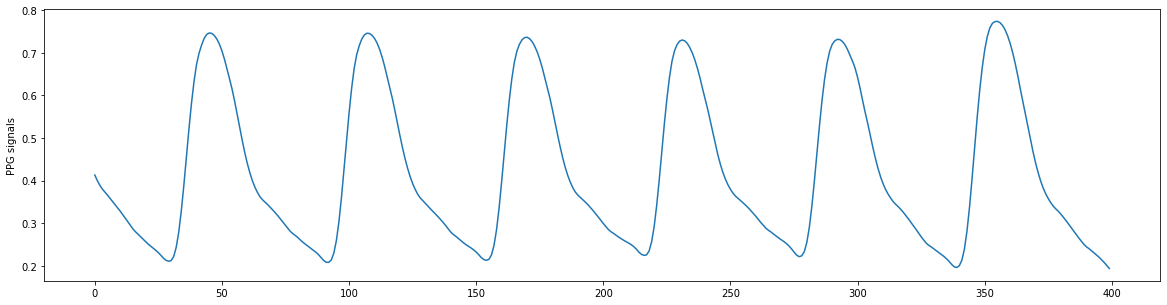

In [6]:
plt.figure(figsize=(20,5))
plt.plot(ex_ppg)
plt.ylabel('PPG signals')
plt.show()

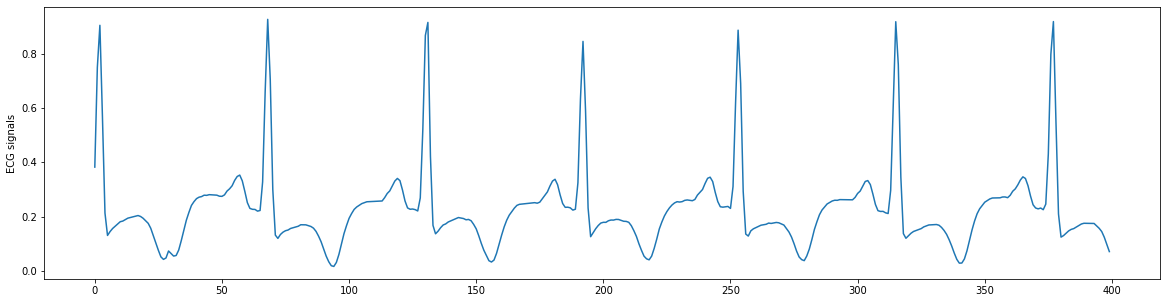

In [7]:
plt.figure(figsize=(20,5))
plt.plot(ex_ecg)
plt.ylabel('ECG signals')
plt.show()

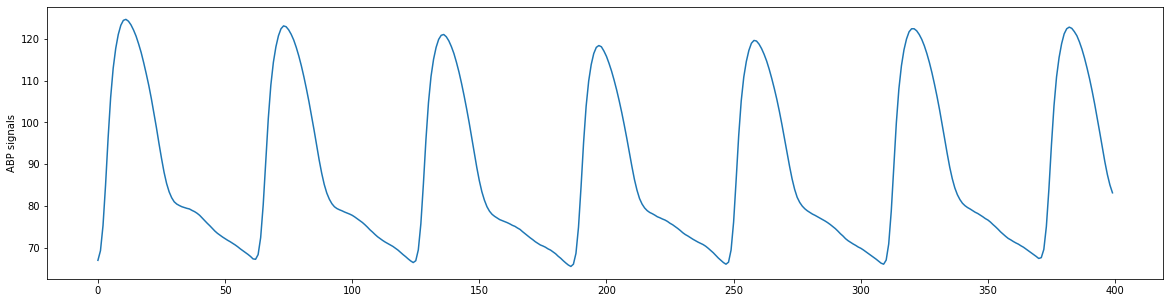

In [8]:
plt.figure(figsize=(20,5))
plt.plot(ex_abp)
plt.ylabel('ABP signals')
plt.show()

## Step 2: Apply Zero-order Holding First Algorithm

To extract Systolic and Diastolic BP for ABP

In [255]:
import numpy as np

In [256]:
MAX_SEQ = 5064

In [257]:
ppg_ecg = []
for i in range(M.shape[0]):
    if M[i][0].shape[0] < MAX_SEQ:
        p = M[i][0]
        for j in range(M[i][0].shape[0], MAX_SEQ):
            p = np.append(p, 0)
        e = M[i][1]
        for j in range(M[i][1].shape[0], MAX_SEQ):
            e = np.append(e, 0)
    else:
        p = M[i][0][:MAX_SEQ]
        e = M[i][1][:MAX_SEQ]
    ppg_ecg.append([p, e])

In [258]:
ppg_ecg = np.array(ppg_ecg)

In [259]:
ppg_ecg.shape

(3000, 2, 5064)

In [260]:
abp = []
for i in range(M.shape[0]):
    if M[i][2].shape[0] < MAX_SEQ:
        a = M[i][2]
        for j in range(M[i][2].shape[0], MAX_SEQ):
            a = np.append(a, 0)
    else:
        a = M[i][2][:MAX_SEQ]
    abp.append(a)

In [261]:
abp = np.array(abp)

In [262]:
abp.shape

(3000, 5064)

In [263]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
import random
random.seed(0)

Training set 68%

In [264]:
train_per = int(M.shape[0] * 68 / 100)

In [265]:
train_per

2040

Valid set 20%

In [266]:
valid_per = int(M.shape[0] * 20 / 100)

In [267]:
valid_per

600

Test set 12%

In [268]:
test_per = int(M.shape[0] * 12 / 100)

In [269]:
test_per

360

In [270]:
def convert_2d(x, index):
    X = []
    for user_i in range(x.shape[0]):
        X.extend(x[user_i][index])
    return np.array(X)

In [271]:
abs_con = convert_2d(M, 2)

In [272]:
abp_all_min = np.min(abs_con)
abp_all_max = np.max(abs_con)

In [273]:
X_train, X, y_train, y = train_test_split(ppg_ecg, abp, random_state=42, test_size=0.32)

In [274]:
X_valid, X_test, y_valid, y_test = train_test_split(X, y, random_state=42, test_size=0.375)

In [275]:
max_len = 64

In [276]:
def to_timeseries(X, y):
    """
    generate data for one user.
    """
    seq_x = []
    seqs_x = []
    seqs_y = []
    seq_y = []
    for i in range(X[0].shape[0]):
        if len(seq_x) < max_len:
            seq_x.append([X[0][i], X[1][i]])
            seq_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        else:
            seq_x = seq_x[1:]
            seq_y = seq_y[1:]
            seq_x.append([X[0][i], X[1][i]])
            seq_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        if len(seq_x) < max_len:
            continue
            ls_x = [[0, 0]] * max_len
            ls_x[:len(seq_x)] = seq_x[:]
            ls_x.reverse()
            ls_y = [[0]] * max_len
            ls_y[:len(seq_y)] = seq_y[:]
            ls_y.reverse()
#             seqs_x.append(ls_x)
#             seqs_y.append(ls_y)
        else:
            seqs_x.append(seq_x)
            if y[i] == 0:
                seqs_y.append(0)
            else:
                seqs_y.append(seq_y[-1][0])
        
    return seqs_x, seqs_y

In [277]:
x = []
y = []
for i in range(train_per):
    s_x, s_y = to_timeseries(X_train[i], y_train[i])
    x.extend(s_x)
    y.extend(s_y)

In [278]:
X_train = np.array(x)
y_train = np.array(y)

In [279]:
y_train.shape

(10202040,)

In [280]:
x = []
y = []
for i in range(valid_per):
    s_x, s_y = to_timeseries(X_valid[i], y_valid[i])
    x.extend(s_x)
    y.extend(s_y)

In [281]:
X_valid = np.array(x)
y_valid = np.array(y)

In [282]:
y_valid.shape

(3000600,)

## Step 4: Create LSTM Network
Skip step 4-5 if you've already train model

In [283]:
from keras.layers import Dense, CuDNNLSTM, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf

In [284]:
def generate_next_batch(x, y, num_set, batch_size=64, is_training=True):
    global max_len

    """
    This generator yields the next training batch
    
    :param batch_size:
        Number of training sequences in a single batch
        
    :return:
        A array of 2 signals in time series and ABP signal point as two numpy arrays
    """
    step = 0
    rand_user = np.random.permutation(x.shape[0])
    rand_range = random.randint(0, x[rand_user[0]][0].shape[0]-101)
    first = rand_user[0]
    range_index = 0
    while True:
        if step == 100//batch_size:
            temp = rand_user[0]
            rand_user = rand_user[1:]
            rand_user = np.append(rand_user, temp)
            rand_range = random.randint(0, x[rand_user[0]][0].shape[0]-101)
            step = 0
            if rand_user[0] == first:
                range_index += 100
            if range_index == 40000:
                range_index = 0
        x_ppg_batch = []
        x_ecg_batch = []
        y_batch = []
        
        x_ppg_sequences = []
        x_ecg_sequences = []
        y_sequences = []
        x_user = x[rand_user[0]]
        y_user = y[rand_user[0]]
        
        if range_index+100 >= x_user.shape[0]:
            x_ppg = x_user[0][rand_range:rand_range+100]
            x_ecg = x_user[1][rand_range:rand_range+100]

            y_abp = y_user[rand_range:rand_range+100]
        else:
            x_ppg = x_user[0][range_index:range_index+100]
            x_ecg = x_user[1][range_index:range_index+100]

            y_abp = y_user[rand_range:rand_range+100]
        
        seq_ppg = []
        seq_ecg = []

        seqs_ppg = []
        seqs_ecg = []
        seqs_y = []
        
        for i in range(x_ppg.shape[0]):
            if len(seq_ppg) < max_len:
                seq_ppg.append(x_ppg[i])
                seq_ecg.append(x_ecg[i])
            else:
                seq_ppg = seq_ppg[1:]
                seq_ecg = seq_ecg[1:]
                seq_ppg.append(x_ppg[i])
                seq_ecg.append(x_ecg[i])
            if len(seq_ppg) < max_len:
                ls_ppg = [0] * max_len
                ls_ppg[:len(seq_ppg)] = seq_ppg[:]
                ls_ppg.reverse()
                ls_ecg = [0] * max_len
                ls_ecg[:len(seq_ecg)] = seq_ecg[:]
                ls_ecg.reverse()
                seqs_ppg.append(ls_ppg)
                seqs_ecg.append(ls_ecg)
            else:
                seqs_ppg.append(seq_ppg)
                seqs_ecg.append(seq_ecg)
    #         seqs_y.append([y[0][i]/max_systolic, y[1][i]/max_diastolic])
            seqs_y.append([(y_abp[i]-abp_all_min)/(abp_all_max-abp_all_min)])
        
        for index in range(batch_size):
            x_ppg_batch.append(seqs_ppg[step*batch_size + index])
            x_ecg_batch.append(seqs_ecg[step*batch_size + index])
            y_batch.append(seqs_y[step*batch_size + index])
        
#         for i in range(x_user[0].shape[0]-(max_len+2)):
#             x_ppg_sequences.append(x_ppg[i:i+max_len])
#             x_ecg_sequences.append(x_ecg[i:i+max_len])
# #             y_sequences.append([y_user[0][i+(max_len)], y_user[1][i+(max_len)]])    
#             y_sequences.append([(y_user[0][i+(max_len)]-sys_all_min)/(sys_all_max-sys_all_min)]) 
  
#         last_sequence = len(y_sequences) - batch_size
#         rand_seq_period = random.randint(0, last_sequence)
        
#         for index in range(batch_size):
#             x_ppg_batch.append(x_ppg_sequences[rand_seq_period + index])
#             x_ecg_batch.append(x_ecg_sequences[rand_seq_period + index])
#             y_batch.append(y_sequences[rand_seq_period + index])
        
        assert len(x_ppg_batch) == batch_size, 'len(x_batch) == batch_size should be True'
        
        step += 1
        
        yield [np.array(x_ppg_batch).reshape(batch_size, max_len, -1), np.array(x_ecg_batch).reshape(batch_size, max_len, -1)], np.array(y_batch)

In [285]:
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [286]:
def create_lstm_network():
    model = Sequential()
    model.add(CuDNNLSTM(64, input_shape=(max_len, 2)))
#     model.add(CuDNNLSTM(32))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[rmse])
    
    model.summary()
    
    return model

In [287]:
model = create_lstm_network()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_16 (CuDNNLSTM)    (None, 64)                17408     
_________________________________________________________________
dense_19 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 17        
Total params: 18,465
Trainable params: 18,465
Non-trainable params: 0
_________________________________________________________________


## Step 5: Train Model
Skip step 4-5 if you've already train model

In [288]:
train_gen = generate_next_batch(X_train, y_train, train_per, is_training=True)
validation_gen = generate_next_batch(X_valid, y_valid, valid_per, is_training=False)

In [289]:
callbacks = [ModelCheckpoint('model.h5', monitor='val_rmse', verbose=1, save_best_only=True, mode='min')]
history = model.fit(x=X_train, y=y_train, batch_size=64,  validation_data=(X_valid, y_valid), epochs=5, callbacks=callbacks)

Train on 10202040 samples, validate on 3000600 samples
Epoch 1/5
  752384/10202040 [=>............................] - ETA: 1:01:27 - loss: 0.0153 - rmse: 0.1216

KeyboardInterrupt: 

## Step 6: Training Evaluation

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation rmse values
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Step 7: Apply Zero-order Holding Second Algorithm

In [153]:
from keras import backend as K
from keras.models import load_model

In [154]:
max_len = 64

In [155]:
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

load our pre-train model

In [156]:
model = load_model('model.h5', custom_objects={'rmse': rmse})

In [214]:
def to_timeseries(X, y):
    """
    generate data for one user.
    """
    seq_x = []
    seqs_x = []
    seqs_y = []
    for i in range(X[0].shape[0]):
        if len(seq_x) < max_len:
            seq_x.append([X[0][i], X[1][i]])
        else:
            seq_x = seq_x[1:]
            seq_x.append([X[0][i], X[1][i]])
        if len(seq_x) < max_len:
            ls_x = [[0, 0]] * max_len
            ls_x[:len(seq_x)] = seq_x[:]
            ls_x.reverse()
#             seqs_x.append(ls_x)
        else:
            seqs_x.append(seq_x)
            if y[i] == 0:
                seqs_y.append(0)
            else:
                seqs_y.append((y[i]-abp_all_min)/(abp_all_max-abp_all_min))
        
    return seqs_x, seqs_y

In [215]:
def generate_next_batch_test(X, y, batch_size=64):
    """
    generate data for testing set for one user.
    """
    step = 0
    seq_ppg = []
    seq_ecg = []

    seqs_ppg = []
    seqs_ecg = []
    seqs_y = []
    for i in range(X[0].shape[0]):
        if len(seq_ppg) < max_len:
            seq_ppg.append(X[0][i])
            seq_ecg.append(X[1][i])
        else:
            seq_ppg = seq_ppg[1:]
            seq_ecg = seq_ecg[1:]
            seq_ppg.append(X[0][i])
            seq_ecg.append(X[1][i])
        if len(seq_ppg) < max_len:
            ls_ppg = [0] * max_len
            ls_ppg[:len(seq_ppg)] = seq_ppg[:]
            ls_ppg.reverse()
            ls_ecg = [0] * max_len
            ls_ecg[:len(seq_ecg)] = seq_ecg[:]
            ls_ecg.reverse()
            seqs_ppg.append(ls_ppg)
            seqs_ecg.append(ls_ecg)
        else:
            seqs_ppg.append(seq_ppg)
            seqs_ecg.append(seq_ecg)
#         seqs_y.append([y[0][i]/max_systolic, y[1][i]/max_diastolic])
        seqs_y.append([(y[i]-abp_all_min)/(abp_all_max-abp_all_min)])
    while True:
        x_ppg_batch = []
        x_ecg_batch = []
        y_batch = []
        
        for index in range(batch_size):
            x_ppg_batch.append(seqs_ppg[step*batch_size + index])
            x_ecg_batch.append(seqs_ecg[step*batch_size + index])
            y_batch.append(seqs_y[step*batch_size + index])

        assert len(x_ppg_batch) == batch_size, 'len(x_batch) == batch_size should be True'
        
        step += 1
        
        yield [np.array(x_ppg_batch).reshape(batch_size, max_len, -1), np.array(x_ecg_batch).reshape(batch_size, max_len, -1)], np.array(y_batch)

In [216]:
user_test = 1

In [217]:
test_x, _ = to_timeseries(X_test[user_test], y_test[user_test])

In [218]:
ground_truth_x, ground_truth_y = to_timeseries(X_test[user_test], y_test[user_test])

In [219]:
prediction = model.predict(np.array(test_x), batch_size=64, verbose=1).flatten()

4987/4987 [==============================] - 0s 53us/step


In [220]:
prediction

array([0.12370464, 0.13814262, 0.18149304, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [239]:
pred_abp = []
gt_abp = []

In [240]:
for i in range(prediction.shape[0]):
    pred_abp.append(prediction[i]*(abp_all_max-abp_all_min)+abp_all_min)
    gt_abp.append(ground_truth_y[i]*(abp_all_max-abp_all_min)+abp_all_min)

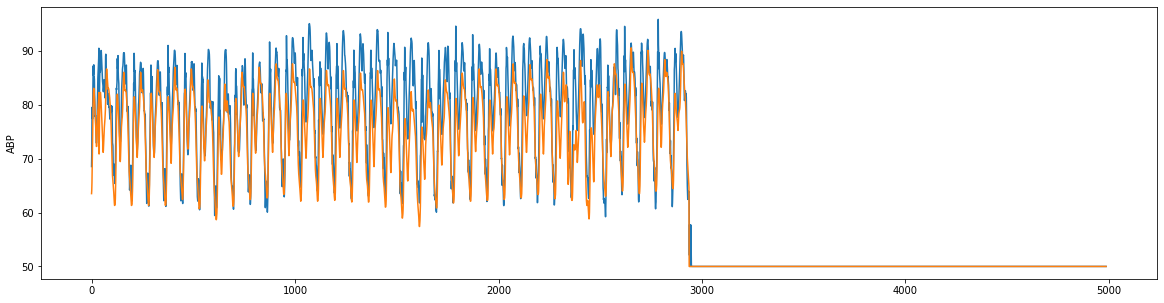

In [241]:
plt.figure(figsize=(20,5))
plt.plot(pred_abp)
# plt.plot(pred_dia)
plt.plot(gt_abp)
# plt.plot(gt_dia)
plt.ylabel('ABP')
plt.show()

In [242]:
def find_abp_peak(abp, delay):
    global max_systolic
    index_max_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        max_value = 0
        max_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j > max_value:
                max_value = j
                max_index = index
                
            index = index + 1
        index_max_abp.append(max_index)
    
    return index_max_abp

In [243]:
def zero_order_holding_first(abp, delay):
    index_max_abp = find_abp_peak(abp, delay)
    peak_abp = np.zeros(len(abp))
    
    j = 0
    for i in range(len(abp)):
        if i < index_max_abp[j]:
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]
        else:
            j = j + 1
            if j >= len(index_max_abp):
                j = j - 1
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]
            
    return peak_abp

In [244]:
pred_sys = zero_order_holding_first(pred_abp, delay=100)
gt_sys = zero_order_holding_first(gt_abp, delay=100)

In [245]:
def find_abp_peak(abp, delay):
    global max_diastolic
    index_min_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    j_value = []
    for i in range(loop_count):
        min_value = 9999999999
        min_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j < min_value:
                min_value = j
                min_index = index
            index = index + 1
        
        index_min_abp.append(min_index)
        j_value.append(min_value)
    return index_min_abp

In [246]:
pred_dia = zero_order_holding_first(pred_abp, delay=60)
gt_dia = zero_order_holding_first(gt_abp, delay=60)

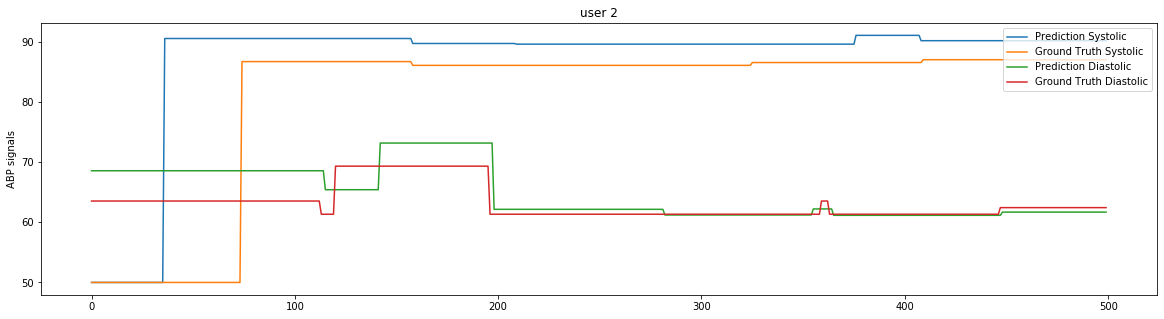

In [247]:
plt.figure(figsize=(20,5))
plt.plot(pred_sys[:500], label='Prediction Systolic')
plt.plot(gt_sys[:500], label='Ground Truth Systolic')
plt.plot(pred_dia[:500], label='Prediction Diastolic')
plt.plot(gt_dia[:500], label='Ground Truth Diastolic')
plt.ylabel('ABP signals')
plt.legend(loc='upper right')
plt.title('user ' + str(user_test+1))
plt.show()

In [248]:
def zero_order_second(signal):
    change = 0
    num = len(signal)
    for i in range(0, num-10):
        counter = 0
        if signal[i+1] != signal[i]:
            change = 1
            for j in range(1, 12):
                if signal[i+j] == signal[i]:
                    counter = counter + 1
        if change == 1 and counter <= 10 and counter > 0:
            for j in range(0, 11):
                signal[i+j] = signal[i]
        change = 0
    return signal

In [249]:
pred_sys = zero_order_second(pred_sys)
gt_sys = zero_order_second(gt_sys)

In [250]:
pred_dia = zero_order_second(pred_dia)
gt_dia = zero_order_second(gt_dia)

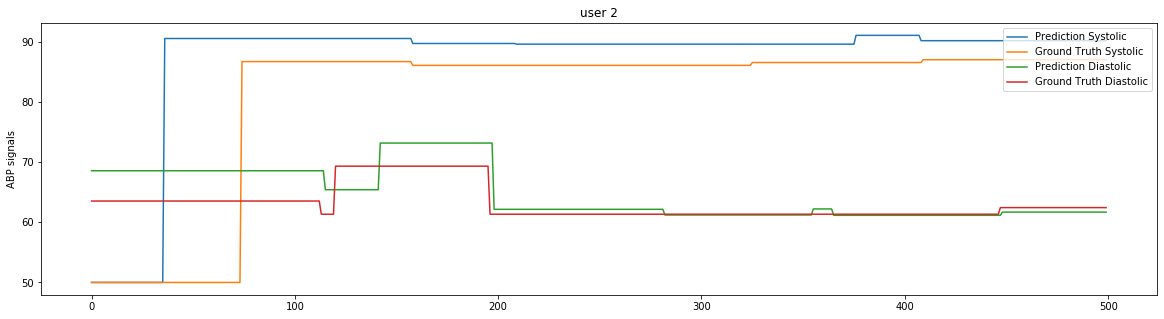

In [251]:
plt.figure(figsize=(20,5))
plt.plot(pred_sys[:500], label='Prediction Systolic')
plt.plot(gt_sys[:500], label='Ground Truth Systolic')
plt.plot(pred_dia[:500], label='Prediction Diastolic')
plt.plot(gt_dia[:500], label='Ground Truth Diastolic')
plt.ylabel('ABP signals')
plt.legend(loc='upper right')
plt.title('user ' + str(user_test+1))
plt.show()

In [252]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_sys = sqrt(mean_squared_error(gt_sys[100:], pred_sys[100:]))
rmse_dia = sqrt(mean_squared_error(gt_dia[100:], pred_dia[100:]))

In [253]:
rmse_sys

4.558433434955356

In [254]:
rmse_dia

2.4726973052080967